# Model-Based Curation Tutorial: Applying Models to Pre-computed Metrics

## Overview

This tutorial demonstrates how to apply pre-trained machine learning models for spike sorting curation using pre-computed quality metrics stored in CSV files. This workflow is ideal when you have existing quality metrics from previous analyses and want to apply automated curation without recomputing all metrics.

In [25]:
# SpikeInterface for neurophysiology workflows
import spikeinterface as si
from spikeinterface.curation import load_model

print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.102.2


## Loading Specialized Models

### Understanding Different Model Types

UnitRefine provides several specialized models for different curation tasks:
- **Noise Neural Classifier**: Identifies units contaminated by noise artifacts
- **SUA/MUA Classifier**: Distinguishes single-unit from multi-unit activity  

Each model is trained on specific datasets and optimized for particular classification challenges.


We'll use the noise neural classifier, which is specifically trained to identify units contaminated by electrical noise, movement artifacts, or other non-neural signals.

In [13]:
model, model_info = load_model(
    repo_id = "SpikeInterface/UnitRefine_noise_neural_classifier",
    trusted = ['numpy.dtype']
)

In [20]:
model

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=4, min_samples_split=3,
                                        n_estimators=150,
                                        random_state=1263805230))])

The model object (an sklearn Pipeline) contains information about which metrics
were used to compute the model. We can access it from the model (or from the model_info)

# Load your metrics files

In [21]:
import pandas as pd

# Load your files
metrics =  pd.read_csv('all_metrics.csv')

In [22]:
columns = model.feature_names_in_

classifier_preds = model.predict(metrics[columns])
classifier_probabs = model.predict_proba(metrics[columns])

In [23]:
print(pd.Series(classifier_preds).map({1: 'noise', 0: 'neural'}))


0       noise
1       noise
2       noise
3       noise
4       noise
        ...  
555    neural
556    neural
557     noise
558    neural
559    neural
Length: 560, dtype: object


## Visualizing Classification Results

Let's create a simple visualization to understand our model's predictions and confidence levels.

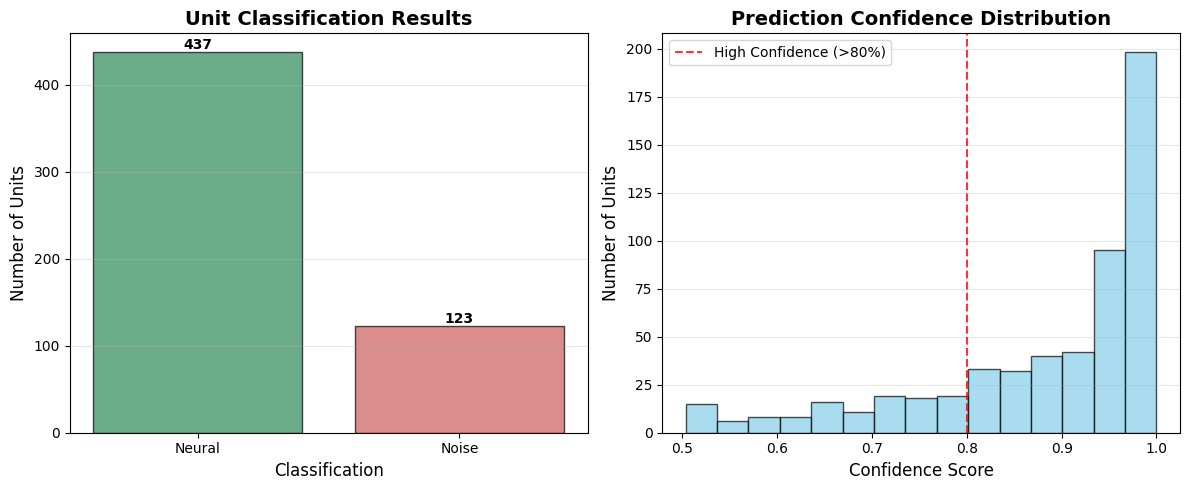

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple visualization of the classification results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Convert predictions to readable labels
pred_labels = pd.Series(classifier_preds).map({1: 'Noise', 0: 'Neural'})
label_counts = pred_labels.value_counts()

# Plot 1: Classification Results Distribution
colors = ['#2E8B57', '#CD5C5C']  # Green for Neural, Red for Noise
bars = ax1.bar(label_counts.index, label_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_title('Unit Classification Results', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classification', fontsize=12)
ax1.set_ylabel('Number of Units', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Prediction Confidence Distribution
max_confidences = np.max(classifier_probabs, axis=1)
ax2.hist(max_confidences, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0.8, color='red', linestyle='--', alpha=0.8, label='High Confidence (>80%)')
ax2.set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Confidence Score', fontsize=12)
ax2.set_ylabel('Number of Units', fontsize=12)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()